In [3]:
import nltk
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re #import the regular expression library
import string
import os
import json
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import load_files
from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords #import the stopwords from the ntlk.corpus library
nltk.download('stopwords')
from nltk.tokenize import word_tokenize #import the word_tokenize method, which is used to turn sentences into words"
nltk.download('punkt')
from collections import Counter
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('wordnet')
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
FullPaper=[]
directories = ["biorxiv_medrxiv"]
for directory in directories: #for each of the three folders carrying the json format of different research papers
    for file in tqdm(os.listdir(f"{directory}/{directory}/pdf_json")): #for every json file
        file_path=f"{directory}/{directory}/pdf_json/{file}" #set the file path to the file_path variable 
        paper = json.load(open(file_path,"rb"))
        title = paper['metadata']['title'] 
        try:
            abstract = paper['abstract']
        except:
            abstarct=""                
        full_text=""     
        
        for text in paper['body_text']:
            full_text += text['text'] +'\n\n' 
        FullPaper.append([title,abstract,full_text])
        
FullPaperDataframe=pd.DataFrame(FullPaper,columns=['title','abstract','full_text'])

100%|██████████| 1934/1934 [01:02<00:00, 31.13it/s]


> Our aim is to address these points:
* Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.

In [68]:
full_text = FullPaperDataframe['full_text'].head(100)
clean_text = [] #a list which will hold all the bodies of the papers after being stripped out of stopwords
wnl = WordNetLemmatizer()
porter = PorterStemmer()
# punctuation_regex = string.punctuation
# punctuation_regex = punctuation_regex.replace("-", "") # keep the hyphens
# pattern = r"[{}]".format(punctuation_regex) # generate the regex pattern
pattern = """!"#$%&'()*+,.:;<=>?@[\]^`{|}~""" #the pattern which will account for punctuation, and will later be used to remove them
#cleaning the data and removing stop words
for val in  tqdm(full_text):
        body_tokens = word_tokenize(val)
        paper_body_without_stopwords = [token.lower() for token in body_tokens if not token.lower() in stopwords.words('english') and nltk.pos_tag([token.lower()])!='PRP'] #remove the stop words in the body and return a list
        clean_string = ' '.join(paper_body_without_stopwords).lower() #convert the list into string
        clean_string = re.sub(rf"[{pattern}]", '', clean_string)#remove punctuation except for hyphens
        clean_string = re.sub(r"\bthe\b", r"", clean_string) #remove the
        clean_string = re.sub(r'\bwe\b', '',clean_string ) #remove the pronoun we
        clean_string = re.sub(r'\bit\b', '',clean_string )#remove the pronoun it
        clean_string = re.sub(r'\bthey\b', '',clean_string )#remove the pronoun they
        clean_string = re.sub(r'\bcopyright\b', '',clean_string )#remove the word copyright
        clean_string = re.sub(r'\bhttps\b', '',clean_string )#remove the word https
        clean_string = re.sub(r'\bet\b', '',clean_string )#remove the word et
        clean_string = re.sub(r'\bal\b', '',clean_string )#remove the word al
        clean_string = re.sub(r'\bpreprint\b', '',clean_string )#remove the word preprint
        clean_string = re.sub(r'\bthis\b', '',clean_string )#remove the word this
        clean_string = re.sub(r'\bthese\b', '',clean_string )#remove the word these
        clean_string = re.sub(r'\balso\b', '',clean_string )#remove the word also
        clean_string = re.sub(r'\bhowever\b', '',clean_string )#remove the word however
        clean_string = re.sub(r'\balthough\b', '',clean_string )#remove the word although
        clean_string = re.sub(r'\bamong\b', '',clean_string )#remove the word among
        clean_string = re.sub(r'\bin\b', '',clean_string )#remove the preposition in
        clean_string = re.sub(r'\bmedrxiv\b', '',clean_string )#remove the word medrxiv
        clean_string = re.sub(r'\bbiorxiv\b', '',clean_string )#remove the word mbiorxiv
        clean_string = re.sub(r'\blicense\b', '',clean_string )#remove the word license
        clean_string = re.sub(r'\bwithout\b', '',clean_string )#remove the word without
        clean_string = re.sub(r'\bfig\b', '',clean_string )#remove the word fig
        clean_string = re.sub(r'\bfigure\b', '', clean_string)#remove the word figure
        clean_string = re.sub(r'\b[a-zA-Z]\b', '', clean_string)#remove all the single letters      

        clean_string = re.sub(r'^\d+\s|\s\d+\s|\s\d+$', '', clean_string) #remove any digit that is not part of a word
        clean_text.append(clean_string) #add the string to the list 
stemmed_text=[] # a list which will contain the stemmed bodies of all docs      
for val in clean_text: #for the body (which was stripped out of stop words) of each paper
    stemmed_val="" #create an empty string
    words = val.split(' ') #split body of paper on spaces
    for word in words: #for each word in the body
        if(word!=""): #if the word is not an empty string
            if (word=="coronaviruses"):#since the stem and lemmatize functions do not recognize the word coronaviruses as the plural of coronavirus, a conidition was created
                word ="coronavirus"
            stem_lemma =wnl.lemmatize(word) if wnl.lemmatize(word).endswith('e') else porter.stem(word)
            stemmed_val+=stem_lemma+" " #stem/lemmatize the word and concat it to the string stemmed_val
    stemmed_text.append(stemmed_val) #add the string stemmed_val to the list which will contain the stemmed bodies of all docs  

100%|██████████| 100/100 [07:55<00:00,  4.75s/it]


In [69]:
# this cell is no longer needed and is kept for reference


text = ' '.join(stemmed_text) #convert all the stemmed bodies into one string containing all the stemmed bodies of all papers 
s=text.split(' ')#split the combination of papers body on space
vocab_count = Counter(s)# count the number of vocab (unique words)
most_occur = vocab_count.most_common(200) #get the most common 200 words
#print(most_occur) #print the most common 200 words

In [70]:
#create a tf-idf matrix for the words above
v = TfidfVectorizer(sublinear_tf = True, min_df = 0.05,max_df = 0.8)
#For the above vectorizer, the first paramater specifies that the 1+log(tf) is going to be used instead of tf.
#The second parameter specifies that if a term appears in less than 5% of the docs, ignore it
#The third parameter, considers word that do not occur in more than 80% of the corpus
tfidf = v.fit_transform(stemmed_text) #fit and transform the stemmed texts which were previously cleaned.
print(sorted(v.vocabulary_.items(), key=lambda x : x[1]))
print(tfidf.toarray())

[('02', 0), ('03', 1), ('08', 2), ('10', 3), ('100', 4), ('11', 5), ('12', 6), ('13', 7), ('14', 8), ('15', 9), ('16', 10), ('17', 11), ('18', 12), ('19', 13), ('1a', 14), ('1b', 15), ('1c', 16), ('1d', 17), ('1e', 18), ('1f', 19), ('20', 20), ('2019', 21), ('2020', 22), ('21', 23), ('22', 24), ('229e', 25), ('23', 26), ('24', 27), ('25', 28), ('26', 29), ('28', 30), ('29', 31), ('2a', 32), ('2b', 33), ('2c', 34), ('2d', 35), ('2e', 36), ('30', 37), ('34', 38), ('35', 39), ('36', 40), ('37', 41), ('38', 42), ('3a', 43), ('3b', 44), ('3c', 45), ('3d', 46), ('3e', 47), ('40', 48), ('48', 49), ('4a', 50), ('4b', 51), ('4c', 52), ('4d', 53), ('4e', 54), ('50', 55), ('56', 56), ('5a', 57), ('5b', 58), ('5c', 59), ('5d', 60), ('5e', 61), ('60', 62), ('64', 63), ('6b', 64), ('72', 65), ('80', 66), ('aa', 67), ('abil', 68), ('able', 69), ('abnorm', 70), ('above', 71), ('absence', 72), ('absent', 73), ('absolute', 74), ('abstract', 75), ('abund', 76), ('abundance', 77), ('academ', 78), ('accele

In [102]:
#Next, the search engine will be implemented with the help of the tf-idf matrix created above and the cosine similarity
pd.set_option('display.max_colwidth', -1)
query = input("Enter your query: ") 
finalQuery="" #create an empty string
words = query.split(' ') #split the query on spaces
for word in words: #for each word in the query
    if(word!=""): #if the word is not an empty string
        if (word=="coronaviruses"):#since the stem and lemmatize functions do not recognize the word coronaviruses as the plural of coronavirus, a conidition was created
            word ="coronavirus"
        stem_lem_query = porter.stem(word)
        finalQuery+=stem_lem_query+" " #stem/lemmatize the word and concat it to the string stemmed_val
query = [finalQuery.strip()]# remove any trailing spaces from the query
query_tfidf = v.transform(query)
cosineSimilarities = cosine_similarity(query_tfidf, tfidf).flatten() #get the cosine similarity list 
answer_indicies = sorted(range(len(cosineSimilarities)), key=lambda i: cosineSimilarities[i])[-5:] #get the top 5 indices with the highest cosine similarity

Enter your query: middle east coronavirus


In [103]:
#loop on the top 5 indicies and display the dataframe
for index in answer_indicies:
    display(FullPaperDataframe.iloc[[index]] )

title  \
11  Forecasting the Worldwide Spread of COVID-19 based on Logistic Model and SEIR Model   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  abstract  \
11  [{'text': 'Background: With the outbreak of coronavirus disease 2019 (COVID-19), a sudden case increase in late February 2020 led to deep concern globally. Italy, South Korea, Iran, France, Germany, Spain, the US and Japan are probably the countries with the most severe outbreaks.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}, {'text': 'Collecting epidemiological data and predicting epidemic trends are important for the development and measurement of public intervention strategies. Epidemic prediction results yielded by different mathematical models are inconsistent; therefore, we sought to compare different models and their prediction results to generate objective conclusions. : medRxiv preprint 2 logistic growth model, basic SEIR model and adjusted SEIR model were adopted for prediction.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}, {'text': 'Given that different model inputs may infer different model outputs, we implemented three model predictions with three scenarios of epidemic development.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}, {'text': ': When comparing all 8 countries' short-term prediction results and peak predictions, the differences among the models were relatively large. The logistic growth model estimated a smaller epidemic size than the basic SERI model did; however, once we added parameters that considered the effects of public health interventions and control measures, the ad

title  \
30  Development of CRISPR as a prophylactic strategy to combat novel coronavirus and influenza   

   abstract  \
30  []        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

title  \
83  In trans variant calling reveals enrichment for compound heterozygous variants in genes involved in neuronal development and growth   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               abstract  \
83  [{'text': 'Compound heterozygotes occur when different mutations at the same locus on both maternal and paternal chromosomes produce a recessive trait. Here we present the tool VarCount for the quantification of mutations at the individual level. We used VarCount to characterize compound heterozygous coding variants in patients with epileptic encephalopathy and in the 1000 genomes participants. The Epi4k data contains variants identified by whole exome sequencing in patients with either Lennox-Gastaut Syndrome (LGS) or Infantile Spasms (IS), as well as their parents. We queried the Epi4k dataset (264 trios) and the phased 1000 genomes data (2504 participants) for recessive variants. To assess enrichment, transcript counts were compared between the Epi4k and 1000 genomes participants using minor allele frequency (MAF) cutoffs of 0.5% and 1.0%, and including all ancestries or only probands of European ancestry. In the Epi4k participants, we found enrichment for rare, compound heterozygous mutations in six genes, including three involved in neuronal growth and development -PRTG (p=0.00086, 1% MAF, combined ancestries), TNC (p=0.0221% MAF, combined ancestries), and MACF1 (p=0.0245, 0.5% MAF, EU ancestry). Due the total number of transcripts considered in these analyses, the enrichment detected was not significant after correction for multiple testing and higher powered or prospective studies are necessary to validate the candidacy of these genes.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}, {'text': 'However, PRTG, TNC, and MACF1 are potential novel recessive epilepsy genes and our results highlight that compound heterozygous mutations should be considered in sporadic epilepsy.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}]   

                                                                                                                                                                                                                                                                                    

title  \
12  TITLE: The early scientific literature response to the novel Coronavirus outbreak: who published what? CORRESPONDING AUTHOR   

                                                                                                                                                                                                                     abstract  \
12  [{'text': 'All rights reserved. No reuse allowed without permission. author/funder, who has granted medRxiv a license to display the preprint in perpetuity.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

title  \
31  A spatial model of CoVID-19 transmission in England and Wales: early spread and peak timing   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               abstract  \
31  [{'text': 'An outbreak of a novel coronavirus, named CoVID-19, was first reported in China on 31 December 2019. As of 9 February 2020, cases have been reported in 25 countries, including probable cases of human-to-human transmission in England.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}, {'text': 'We adapted an existing national-scale metapopulation model to capture the spread of CoVID-19 in England and Wales. We used 2011 census data to capture population sizes and population movement, together with parameter estimates from the current outbreak in China.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}, {'text': 'We predict that a CoVID-19 outbreak will peak 126 to 147 days (~4 months) after the start of person-to-person transmission in England and Wales in the absence of controls, assuming biological parameters remain unchanged. Therefore, if person-to-person transmission persists from February, we predict the epidemic peak would occur in June. The starting location has minimal impact on peak timing, and model stochasticity varies peak timing by 10 days. Incorporating realistic parameter uncertainty leads to estimates of peak time ranging from 78 days to 241 days after person-to-person transmission has been established. Seasonal changes in transmission rate substantially impact the timing and size of the epidemic peak, as well as the total attack rate.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}, {'text': 'We provide initial estimates of the potential course of CoVID-19 in England and Wales in the absence of control measures. These results can be refined with improved estimates of epidemiological parameters, and permit investigation of control measures and cost effectiveness analyses. Seasonal changes in transmission rate could shift the timing of the peak into winter months, which will have important implications 

In [71]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.90,random_state=30) #keep 90% of the variance
tf_idf_norm_kmeans= pca.fit_transform(tfidf.toarray())

100%|██████████| 29/29 [00:04<00:00,  6.01it/s]


<Figure size 1440x1440 with 0 Axes>

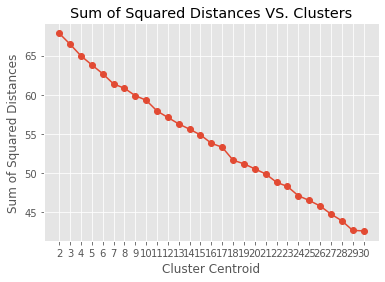

<Figure size 1440x1440 with 0 Axes>

In [72]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
plt.style.use('ggplot')
max_number_of_clusters = 30
max_number_of_clusters = max_number_of_clusters+1 # since the range method is exclusive, a one should be added.
Ks = range(2, max_number_of_clusters, 1) #Hold the range of clusters k (from 2-max_number_of_clusters)
    
sum_of_squared_distances = [] #a list which will carry the sum of squared distances at each k
for k in tqdm(Ks):
    sum_of_squared_distances.append(KMeans(n_clusters=k,random_state=30).fit(tf_idf_norm_kmeans).inertia_)#calculate the sum of squared distance.
        
        
f, ax = plt.subplots(1, 1)
ax.plot(Ks, sum_of_squared_distances, marker='o')
ax.set_xlabel('Cluster Centroid')
ax.set_xticks(Ks)
ax.set_xticklabels(Ks)
ax.set_ylabel('Sum of Squared Distances')
ax.set_title('Sum of Squared Distances VS. Clusters')
plt.figure(figsize=(20,20))

In [80]:
clusters = KMeans(n_clusters=16).fit_predict(tf_idf_norm_kmeans)
df =FullPaperDataframe.head(100).copy(deep=True)

In [81]:
df['clusters'] = clusters
df.head()

,title,abstract,full_text,clusters
0,The RNA pseudoknots in foot-and-mouth disease ...,[{'text': 'word count: 194 22 Text word count:...,"VP3, and VP0 (which is further processed to VP...",1
1,Analysis Title: Regaining perspective on SARS-...,"[{'text': 'During the past three months, a new...","In December 2019, a novel coronavirus, SARS-Co...",10
2,Healthcare-resource-adjusted vulnerabilities t...,[],The 2019-nCoV epidemic has spread across China...,7
3,Relationship between Average Daily Temperature...,[{'text': 'The rapid outbreak of the new Coron...,The outbreak of infectious diseases has always...,4
4,CHEER: hierarCHical taxonomic classification f...,[{'text': 'The fast accumulation of viral meta...,"Metagenomic sequencing, which allows us to dir...",10


In [75]:
#tf- idf
# # finding the tf-idf matrix for all the abstracts
# # vec = TfidfVectorizer()

# # ve = vec.fit_transform(clean_abs)

# # # displaying the tf-idf of the word in the abstact  
# # pd.DataFrame(ve.toarray(), columns=sorted(vec.vocabulary_.keys()))

# # #applying tf-idf cosine similarity and printing the result(testing)
# # query = ["prophylaxis"]
# # query_tfidf = vec.transform(query)
# # cosineSimilarities = cosine_similarity(query_tfidf, ve).flatten()
# # print(cosineSimilarities)

In [ ]:
# taged_abs=[]
# nouns=[]
# # tagging the clean data
# for val in clean_abs:
#     taged_abs.append(pos_tag(val.split()))
# # extracting the nouns
# for i in range(len(taged_abs)):
#     doc=[]
#     for j in range(len(taged_abs[i])):
#         if(taged_abs[i][j][1]=='NN' or taged_abs[i][j][1]=='NNS'):
#             doc.append(taged_abs[i][j][0])
#     nouns.append(doc)
        
# print(nouns)



Above we dcided to calculate the tf-idf so that we can represent every word that is present in the abstract quatitavily. By doing so we can further use the results in order model the topic according to the abstract that we just quatified.Furthermore we will use (Non-negative Matrix Factorization) NMF in order to come up with topic's that carry most weight in the abstract. To accomplish this we are going to filter all the nouns that are avaliable in the abstract and use them to represent the different topis that are avaliable.